# Introduction

This project is about classifying radio signals on whether or not they are pulsars using machine learning. I will be following the data science workflow described in the image below. In this notebook I will be using RandomForestClassifier from sklearn to create my model.

<img src=Data_Science_Process.png>

# 1 Business Understanding

Pulsar stars are a type of neutron star that are highly magnetized and rotate rapidly. They emit radio pulses at regular intervals. They can be used by astronomers as a way of tracking time. They can also be used to help search for gravitational waves. (Source: https://www.universetoday.com/25376/pulsars/) Other uses of them can be to learn about space-time, the interstellar medium, and states of matter. (Source: https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star)

When the radio signals are captured by a telescope each pulse looks different so astronomers stack the pulses on top of one another to create what is called the integrated pulse profile. Also, the pulses will arive at various time intervals at various frequencies, this is called "dispersion" and is caused by matter in the interstellar medium. Astronomers use approxomations to try to compensate for the shifts and create what is called a DM-SNR curve which stands for “dispersion-measure-signal-to-noise-ratio”. (Source: https://as595.github.io/classification/)

This dataset from https://www.kaggle.com contains radio signals that are candadites for pulsar stars. The data was collected from the High Time Resolution Universe Survey. The data set is called "HTRU2".
(Source: https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star)

The dataset contains eight continous variables and a class variable. The first four variables are simple statistics from the integrated pulse profile. The other four variables are from the DM-SNR curve. (Source: https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star)

# 2 Data Mining

First I will import necessary libaries.

In [93]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_score, f1_score, accuracy_score, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import kstest

Next I will import the data into a pandas dataframe.

In [94]:
data = pd.read_csv('pulsar_stars.csv')
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


# 3 Data Cleaning

First I will rename the columns. I got this idea from a user's post on kaggle. (Source https://www.kaggle.com/pavanraj159/predicting-pulsar-star-in-the-universe)

In [95]:
data.columns = ["mean_profile", "std_profile", "excess_kurtosis_profile", "skewness_profile", "mean_curve", "std_curve",
                "excess_kurtosis_curve", "skewness_curve", "target_class"]

Next I will look at the data info to check for null values and to double check the datatypes of each column.

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
mean_profile               17898 non-null float64
std_profile                17898 non-null float64
excess_kurtosis_profile    17898 non-null float64
skewness_profile           17898 non-null float64
mean_curve                 17898 non-null float64
std_curve                  17898 non-null float64
excess_kurtosis_curve      17898 non-null float64
skewness_curve             17898 non-null float64
target_class               17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


All of the columns are either float64 or int64 and there are no missing values. Next I will check for duplicate data.

In [97]:
data.duplicated().sum()

0

There are no duplicate values. Next I will visualy check for multicolinearity.

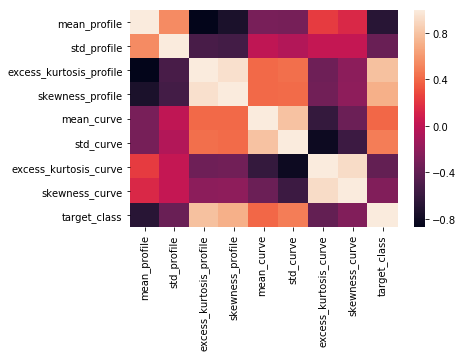

In [98]:
sns.heatmap(data.corr())

We can see here that we have several columns that have high multicolinearity negatively and positively. I will ignore these for now and use PCA to fix this later on. I will further inspect multicolinarity using a table.

In [99]:
df_corr = abs(data.drop('target_class', axis=1).corr() > 0.75)
df_corr

,mean_profile,std_profile,excess_kurtosis_profile,skewness_profile,mean_curve,std_curve,excess_kurtosis_curve,skewness_curve
mean_profile,True,False,False,False,False,False,False,False
std_profile,False,True,False,False,False,False,False,False
excess_kurtosis_profile,False,False,True,True,False,False,False,False
skewness_profile,False,False,True,True,False,False,False,False
mean_curve,False,False,False,False,True,True,False,False
std_curve,False,False,False,False,True,True,False,False
excess_kurtosis_curve,False,False,False,False,False,False,True,True
skewness_curve,False,False,False,False,False,False,True,True


Excess kurtosis of the DM-SNR curve and skewness of the DM-SNR curve are correlated. <br>
Mean of the DM-SNR curve and Standard deviation of the DM-SNR curve are correlated. <br>
Excess kurtosis of the integrated profile and skewness of the integrated profile are correlated. <br>
I will address this later on with PCA.

# 4 Data Exploration

First I will check the basic statistics of the data. This will give me an idea of the variance and scale of the data. I will also plot the distribution of each feature using a seaborn distplot so I can get a visual representation of the data.

In [100]:
data.describe()

,mean_profile,std_profile,excess_kurtosis_profile,skewness_profile,mean_curve,std_curve,excess_kurtosis_curve,skewness_curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


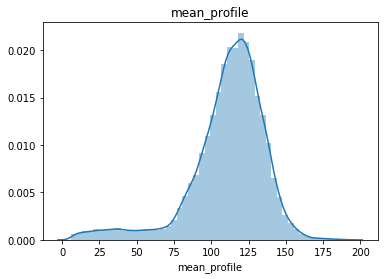

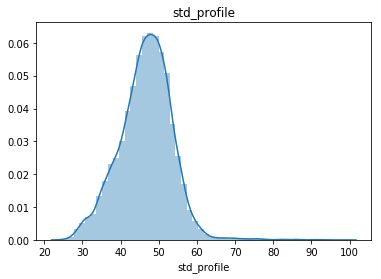

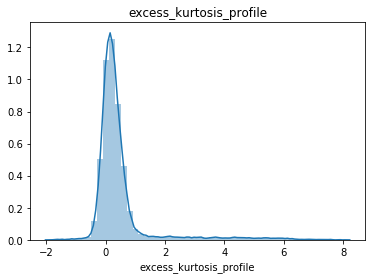

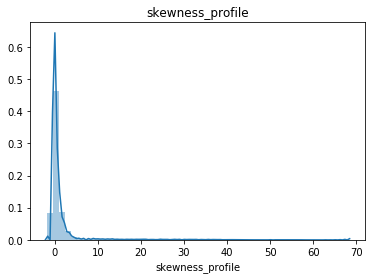

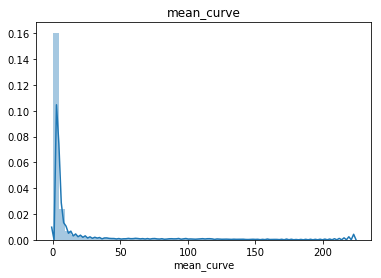

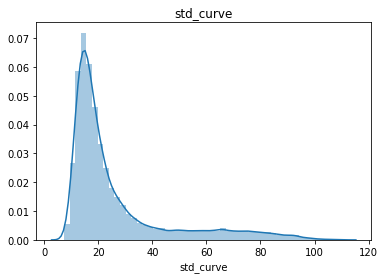

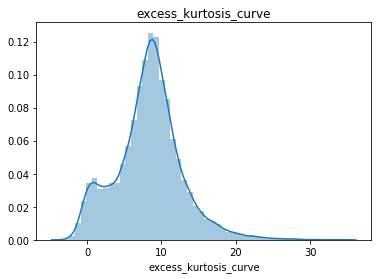

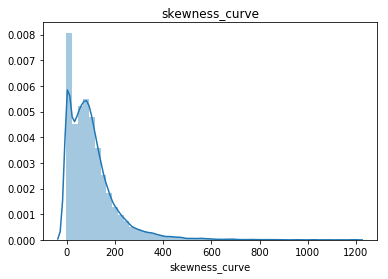

In [101]:
for feat in data.columns[:-1]:
    sns.distplot(data[feat])
    plt.title(feat)
    plt.show()

We can see here that some features' values are much higher than others and some have much more variance than others. The higher values can be fixed with scaling. It also appears that none of the features are normally distributed so I will be using MinMaxScaler.

Next I will see how much of each class exists.

0    0.908426
1    0.091574
Name: target_class, dtype: float64


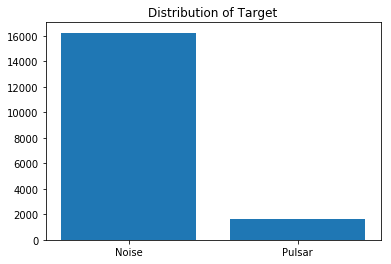

In [102]:
print(data.target_class.value_counts(normalize=True))
plt.bar(['Noise', 'Pulsar'], data.target_class.value_counts())
plt.title("Distribution of Target")
plt.show()

So about 90% of the signals are noise and about 10% are pulsars. This means the data set is imbalanced and this could lead to bias in the machine learning model. I will deal with this in the feature engineering section using the SMOTE algorithm.

Next I will create seaborn distribution plots for each feature. I will create one plot for rows with a target class of 0 and one plot for rows with a target class of 1. I will do this to get a general overview of what the data looks like when split by class.

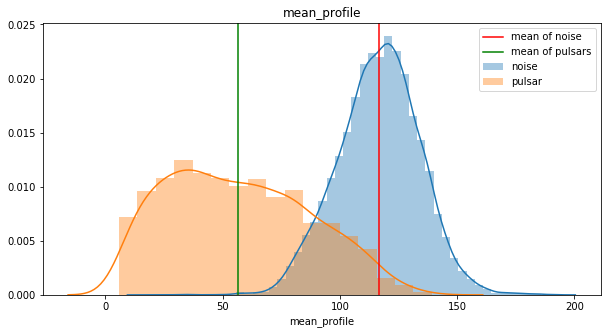

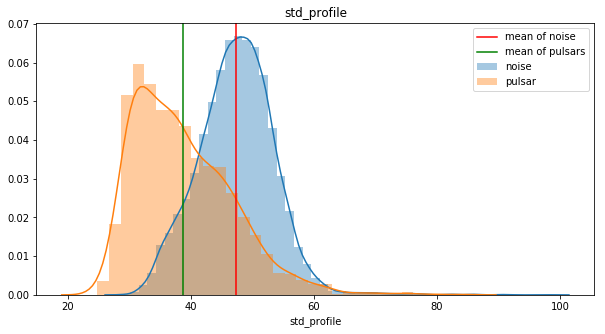

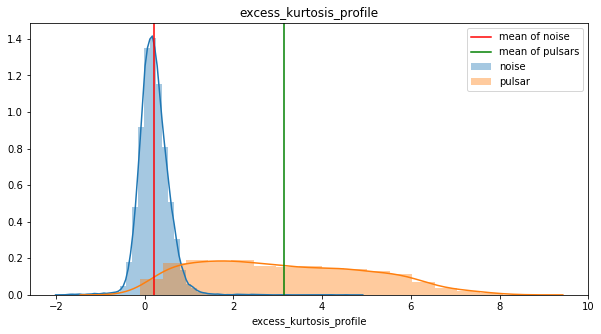

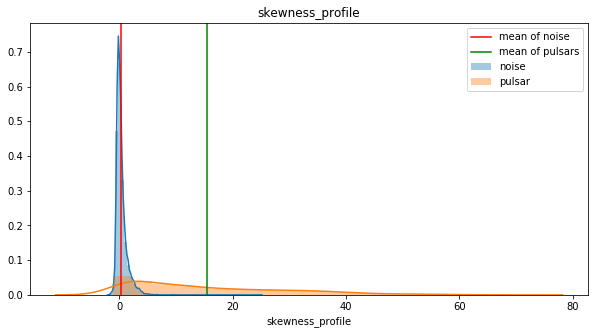

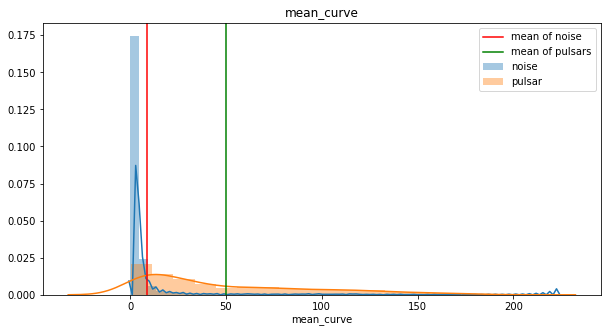

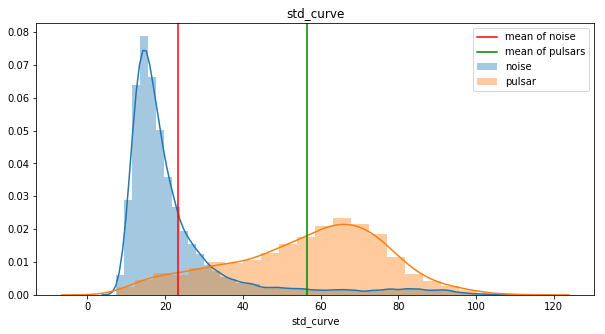

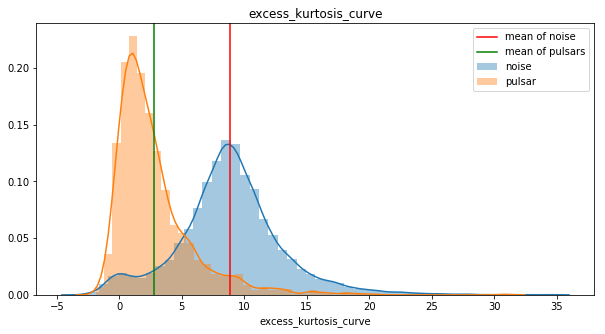

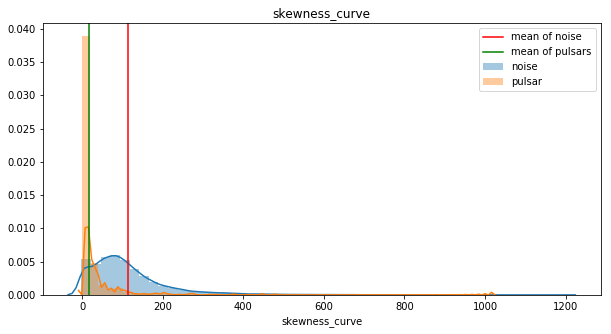

In [103]:
for feat in data.drop('target_class', axis=1).columns:
    
    # split feature by target class
    noise = data[data['target_class']==0][feat]
    pulsar = data[data['target_class']==1][feat]
    
    # plot
    plt.figure(figsize=(10,5))
    sns.distplot(noise, label='noise')
    sns.distplot(pulsar, label='pulsar')
    plt.axvline(noise.mean(), label='mean of noise', color="red")
    plt.axvline(pulsar.mean(), label='mean of pulsars', color="green")
    plt.title(feat)
    plt.legend()
    plt.show()

It seems that each class occupies each feature quite differently. In excess_kurtosis_profile we can see that pulsars have much more variance than the noise.

# 5 Feature Engineering

First I will seperate the data into the features (X) and the target (y).

In [104]:
X = data.drop("target_class", axis=1)
y = data.target_class

Then I will scale the features. I will use StandardScaler if the features of the datset are normally distributed and MinMaxScaler if they are not. So in the cell below I will double check to see if any features are normally distributed.

In [105]:
for feat in X.columns:
    
    # ks test
    stat, pval = kstest(X[feat], "norm", args=(X[feat].mean(), X[feat].std()))
    if pval > 0.05:
        print(feat, "is normally distributed")
    else:
        print(feat, "is NOT normally distributed")

mean_profile is NOT normally distributed
std_profile is NOT normally distributed
excess_kurtosis_profile is NOT normally distributed
skewness_profile is NOT normally distributed
mean_curve is NOT normally distributed
std_curve is NOT normally distributed
excess_kurtosis_curve is NOT normally distributed
skewness_curve is NOT normally distributed


Since none of the data is normally distributed I will use MinMaxScaler.

In [106]:
mm = MinMaxScaler()
mm.fit(X)
X = mm.transform(X)

Now I will perform PCA to deal with multicolinearity and to help speed up modeling by reducing dimensionality. I will keep the original data as well to compare how the model works with and without PCA.

Total variance explained with value 2: 82.05 %
[0.58134036 0.82050144] 



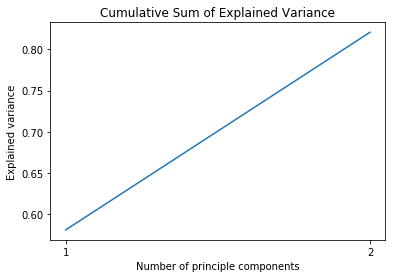

Total variance explained with value 3: 90.09 %
[0.58134036 0.82050144 0.90091429] 



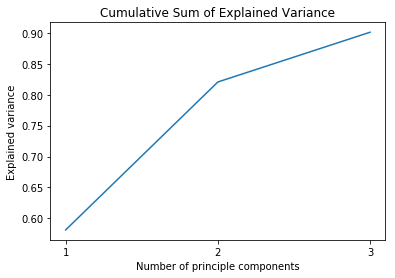

Total variance explained with value 4: 94.1 %
[0.58134036 0.82050144 0.90091429 0.94099756] 



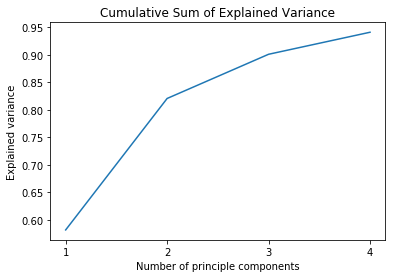

Total variance explained with value 5: 97.13 %
[0.58134036 0.82050144 0.90091429 0.94099756 0.97125949] 



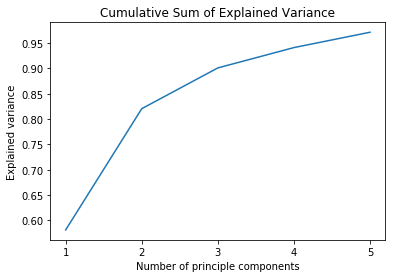

Total variance explained with value 6: 99.67 %
[0.58134036 0.82050144 0.90091429 0.94099756 0.97125949 0.99672022] 



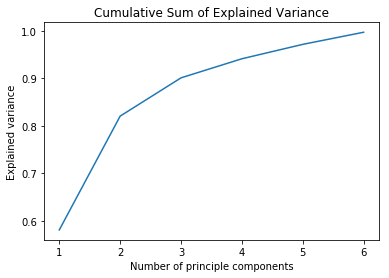

In [107]:
for value in [2, 3, 4, 5, 6]:

    pca = PCA(value, random_state=3)
    X_pca = pca.fit(X)
    print("Total variance explained with value {}:".format(value), round(sum(pca.explained_variance_ratio_)*100,2) , "%")
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    print(cumsum, '\n')

    # plotting
    plt.plot(np.array((range(value))) + 1, cumsum)
    plt.title("Cumulative Sum of Explained Variance")
    plt.xlabel("Number of principle components")
    plt.xticks(np.array((range(value))) + 1)
    plt.ylabel("Explained variance")
    plt.show()


Since using a pca value of 6 gets %99 of the variance explained I will use PCA with a value of 6.

In [108]:
pca = PCA(6, random_state=3)
X_pca = pca.fit_transform(X)

Next I will perform a train test split on the data. I will have one set of data with PCA and another without PCA.

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [110]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=3)

Now I will implement the SMOTE algorithm to upsample the data. This will deal with the bias that can come from the data being imbalanced. I will save the orginal data to try it out as well.

##### SMOTE algorithm

First I will check the value counts of the target class.

In [111]:
print("y_train")
print(y_train.value_counts())
print('\n')
print("y_train_pca")
print(y_train_pca.value_counts())

y_train
0    11377
1     1151
Name: target_class, dtype: int64


y_train_pca
0    11377
1     1151
Name: target_class, dtype: int64


Now I will fit a SMOTE object to the training data and upsample it.

In [112]:
sm = SMOTE(random_state=3)

# non pca X_train and y_train
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train) 

# pca X_train and y_train
X_train_pca_sm, y_train_pca_sm = sm.fit_resample(X_train_pca, y_train_pca)

Now I will check the value counts of the target class again.

In [113]:
print("y_train_sm")
print(pd.Series(y_train_sm).value_counts())
print("\n")
print("y_train_pca_sm")
print(pd.Series(y_train_pca_sm).value_counts())

y_train_sm
1    11377
0    11377
dtype: int64


y_train_pca_sm
1    11377
0    11377
dtype: int64


# 6 Predictive Modeling

For this dataset I will use precision, f1-score, and accuracy as my measures of performance. Since we do not want false positives or false negatives, and false positives are likely to be more detrimental than false negatives.

I will create a RandomForestClassifier from sklearn and use GridSearchCV to find the best hyper parameters for each set of training data. This cell takes a very long time to run. I would suggest not even running this cell.

In [114]:
# RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=3)

# param grid
param_grid = {
    "n_estimators" : [10, 20],
    "max_depth" : [None, 2, 5],
    "min_samples_split" : [2, 3],
    "min_samples_leaf" : [2, 3],
    "n_jobs" : [None, 1, 2]
    
 }

# grid search
gs = GridSearchCV(rf_clf, param_grid, cv=5, return_train_score=True, scoring="f1")

# fitting and finding best params

# model w/o PCA
print('model w/o PCA \n')
model = gs.fit(X_train, y_train)
model_best_params = gs.best_params_ # store best hyper parameters
y_train_hat = gs.predict(X_train)
y_test_hat = gs.predict(X_test)

print('model training precision =', precision_score(y_train, y_train_hat))
print('model training f1-score =', f1_score(y_train, y_train_hat))
print('model training accuracy =', accuracy_score(y_train, y_train_hat))
print('\n')
print('model testing precision =', precision_score(y_test, y_test_hat))
print('model testing f1-score =', f1_score(y_test, y_test_hat))
print('model testing accuracy =', accuracy_score(y_test, y_test_hat))

print('\nmodel w/o pca classification report')
print(classification_report(y_test, y_test_hat))
print('\n\n')


# model w/ PCA
print('model w/ PCA \n')
pca_model = gs.fit(X_train_pca, y_train_pca)
pca_model_best_params = gs.best_params_ # store best hyper parameters
pca_y_train_hat = gs.predict(X_train_pca)
pca_y_test_hat = gs.predict(X_test_pca)

print('model w/ pca training precision =', precision_score(y_train_pca, pca_y_train_hat))
print('model w/ pca training f1-score =', f1_score(y_train_pca, pca_y_train_hat))
print('model w/ pca training accuracy =', accuracy_score(y_train_pca, pca_y_train_hat))
print('\n')
print('model w/ pca testing precision =', precision_score(y_test_pca, pca_y_test_hat))
print('model w/ pca testing f1-score =', f1_score(y_test_pca, pca_y_test_hat))
print('model w/ pca testing accuracy =', accuracy_score(y_test_pca, pca_y_test_hat))

print('\n SMOTE model w/o pca classification report')
print(classification_report(y_test_pca, pca_y_test_hat))
print('\n\n')


# SMOTE model w/o PCA
print('SMOTE model w/o PCA \n')
sm_model = gs.fit(X_train_sm, y_train_sm)
sm_model_best_params = gs.best_params_ # store best hyper parameters
sm_model_y_train_hat = gs.predict(X_train_sm)
sm_model_y_test_hat = gs.predict(X_test)

print('SMOTE model training precision =', precision_score(y_train_sm, sm_model_y_train_hat))
print('SMOTE model training f1-score =', f1_score(y_train_sm, sm_model_y_train_hat))
print('SMOTE model training accuracy =', accuracy_score(y_train_sm, sm_model_y_train_hat))
print('\n')
print('SMOTE model testing precision =', precision_score(y_test, sm_model_y_test_hat))
print('SMOTE model testing f1-score =', f1_score(y_test, sm_model_y_test_hat))
print('SMOTE model testing accuracy =', accuracy_score(y_test, sm_model_y_test_hat))

print('\n SMOTE model w/o pca classification report')
print(classification_report(y_test, sm_model_y_test_hat))
print('\n\n')


# SMOTE model w/ PCA
print('SMOTE model w/ PCA \n')
pca_sm_model = gs.fit(X_train_pca_sm, y_train_pca_sm)
pca_sm_model_best_params = gs.best_params_ # store best hyper parameters
pca_sm_model_y_train_hat = gs.predict(X_train_pca_sm)
pca_sm_model_y_test_hat = gs.predict(X_test_pca)

print('SMOTE model w/ pca training precision =', precision_score(y_train_pca_sm, pca_sm_model_y_train_hat))
print('SMOTE model w/ pca training f1-score =', f1_score(y_train_pca_sm, pca_sm_model_y_train_hat))
print('SMOTE model w/ pca training accuracy =', accuracy_score(y_train_pca_sm, pca_sm_model_y_train_hat))
print('\n')
print('SMOTE model w/ pca testing precision =', precision_score(y_test_pca, pca_sm_model_y_test_hat))
print('SMOTE model w/ pca testing f1-score =', f1_score(y_test_pca, pca_sm_model_y_test_hat))
print('SMOTE model w/ pca testing accuracy =', accuracy_score(y_test_pca, pca_sm_model_y_test_hat))

print('\n SMOTE model w/ pca classification report')
print(classification_report(y_test, sm_model_y_test_hat))

model w/o PCA 

model training precision = 0.976280834914611
model training f1-score = 0.9333333333333333
model training accuracy = 0.9882662835249042


model testing precision = 0.9269406392694064
model testing f1-score = 0.8768898488120951
model testing accuracy = 0.9787709497206704

model w/o pca classification report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4882
           1       0.93      0.83      0.88       488

    accuracy                           0.98      5370
   macro avg       0.96      0.91      0.93      5370
weighted avg       0.98      0.98      0.98      5370




model w/ PCA 

model w/ pca training precision = 0.9794520547945206
model w/ pca training f1-score = 0.9213069489185457
model w/ pca training accuracy = 0.9863505747126436


model w/ pca testing precision = 0.9285714285714286
model w/ pca testing f1-score = 0.8590308370044054
model w/ pca testing accuracy = 0.9761638733705773

 SMOTE model w/o p

I am going to choose the non-smote model without PCA because it had high precision and f1_score.

In [115]:
# this cell will give an error if you skipped the precious cell|
# check the hyper parameters
model_best_params

{'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 20,
 'n_jobs': None}

In [116]:
# create final model
model = RandomForestClassifier(max_depth=None,
                              min_samples_leaf=3,
                              n_estimators=20,
                              random_state=3)

# fit model
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)
print("Training precision =", precision_score(y_train, y_train_hat))
print("Training f1_score =", f1_score(y_train, y_train_hat))
print("Training accuracy =", accuracy_score(y_train, y_train_hat))
print('\n')
print("Testing precision =", precision_score(y_test, y_test_hat))
print("Testing f1_score =", f1_score(y_test, y_test_hat))
print("Testing accuracy =", accuracy_score(y_test, y_test_hat))

print('\n Classification report')
print(classification_report(y_test, y_test_hat))

Training precision = 0.976280834914611
Training f1_score = 0.9333333333333333
Training accuracy = 0.9882662835249042


Testing precision = 0.9269406392694064
Testing f1_score = 0.8768898488120951
Testing accuracy = 0.9787709497206704

 Classification report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4882
           1       0.93      0.83      0.88       488

    accuracy                           0.98      5370
   macro avg       0.96      0.91      0.93      5370
weighted avg       0.98      0.98      0.98      5370



# 7 Data Visualization

Here I will show a simple confusion matrix to show false positives and false negatives.

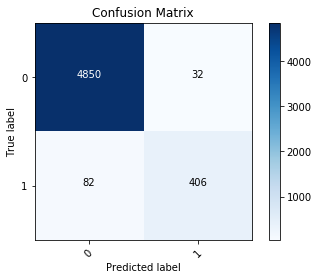

In [117]:
cnm = confusion_matrix(y_test, y_test_hat)

# Create the basic matrix
plt.imshow(cnm,  cmap=plt.cm.Blues) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
class_names = set(y) # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = cnm.max() / 2. # Used for text coloring below
# iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnm.shape[0]), range(cnm.shape[1])):
        plt.text(j, i, cnm[i, j],
                 horizontalalignment='center',
                 color='white' if cnm[i, j] > thresh else 'black')

# Add a legend
plt.colorbar()
plt.show()

Next I will show the Roc curve and AUC to compare with other models.

In [118]:
y_score = model.predict_proba(X_test)[:,1]

AUC: 0.9697819356485181


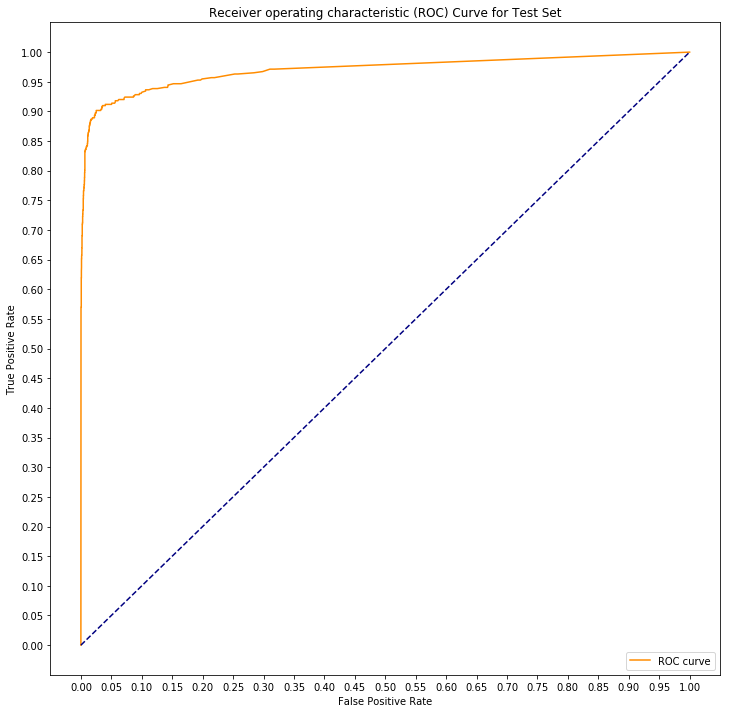

In [119]:
# calcualate true positive rate and false positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# plotting
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')

# AUC
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

# Conclusion

The model performs well with a testing precision score of 0.93, f1-score of 0.88, an accuracy of 0.98 and an AUC of 0.97. This model was built with a RandomForestClassifier from sklearn. I will compare this algorithm to other machine learning algorithms and find the best possible model.

# Future work

Data Science can be used by astronomers in many ways. Given more time
and data I could classify all types of stars, galaxies and other astronomical
phenomena using my skills as a data scientist. 